# Figure 1

In [1]:
library(readxl)
library(ggpubr)
library(patchwork)
library(pheatmap)
library(ggrepel)
library(wesanderson)
library(ggdendroplot)
library(zoo)
library(dendextend)
library(parallel)
source("func.R")

Loading required package: ggplot2


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



---------------------
Welcome to dendextend version 1.17.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: 'dendextend'


The following object is masked from 'package:ggpubr':

    rotate


The following object is masked from 'package:stats':

    cutree



Attaching package: 'data.table'


The following object is masked from 'package:dendextend':

   

## From polyG to phylogenetic tree (Figure 1C)

Manually identified that Sal21 has representative mutations

In [2]:
sal21 <- read_tsv("../data/multiple_lung_cancers/TM32_0.1_20211220_R/repre_repli_data/Sal21_TM32_0.1_repre_repli.txt")

Rows: 7 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
dbl (4): TM32N1_2, TM32P1_3, TM32P2a_3, TM32P2b_3

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Plotting allele frequencies side by side

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


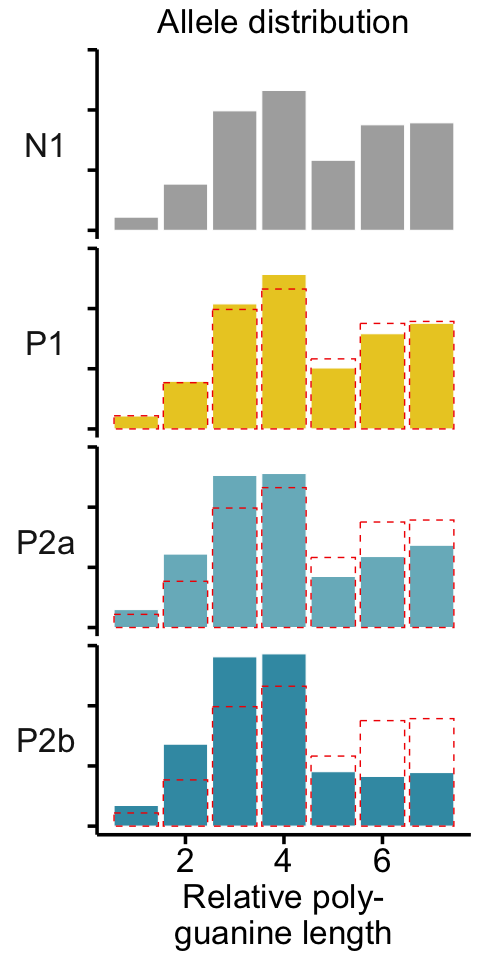

In [3]:
options(repr.plot.width=4, repr.plot.height=8)

sal21 %>%
  rowid_to_column("length") %>%
  pivot_longer(cols = c(2:5), names_to = "sample", values_to = "Frequency") %>%
  group_by(sample) %>%
  mutate(
    Frequency = Frequency / sum(Frequency),
    sample = str_remove(sample, "_[1-3]$")
  ) %>%
  group_by(length) %>%
    mutate(n_Frequency = Frequency[sample == "TM32N1"],
    sample=str_remove(sample, "TM32")) %>%
    ggplot(aes(length, Frequency)) +
    geom_col(aes(fill = sample), color="white", size=0.3) +
    geom_col(data=.%>% filter(sample!="N1"), 
      aes(length, n_Frequency), linewidth=0.4, color=wes_palette("Zissou1")[5], alpha=0, linetype=14) +
    scale_fill_manual(values = c("grey68", wes_palette("Zissou1")[3],  wes_palette("Zissou1")[2],  wes_palette("Zissou1")[1]),guide = "none") +
    theme_martin() +
    facet_wrap(~ sample, nrow = 4, strip.position = "left") +
    theme(plot.title = element_text(hjust = 0.5, size=20),
      strip.background = element_blank(),
      strip.placement = "outside", 
      strip.text.y.left = element_text(angle = 0, size=20),
      axis.text.y = element_blank(), axis.title.y = element_blank(),
      axis.text.x=element_text(size=20), axis.title.x=element_text(size=20)
         ) +
    labs(title="Allele distribution", x="Relative poly-\nguanine length")

ggsave("../plots/Figure1/sal21_plot.pdf", width=2.5, height=8)

Mean lengths:

In [5]:
sal21  %>% 
    rowid_to_column("length")  %>% 
    pivot_longer(cols=c(2:5), names_to="sample", values_to="Frequency")  %>% 
    group_by(sample)  %>% 
    mutate(Frequency=Frequency/sum(Frequency),
            sample=str_remove(sample, "_[1-3]$"))  %>% 
    summarize(mean=sum(length*Frequency)) 

sample,mean
<chr>,<dbl>
TM32N1,4.585166
TM32P1,4.513884
TM32P2a,4.144556
TM32P2b,3.866051


Heatmap of mean length from Normal:

In [2]:
mean_lengths <- read_tsv("../results/lung_markerlengths_tm32b.tsv") %>%
    mutate(sample=str_remove(sample, "TM32")) 

Rows: 2684 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): sample, marker, subject
dbl (1): length

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# selecting only case TM32 
mean_lengths_tm32  <- mean_lengths  %>% 
    filter(subject=="TM32")

In [4]:
# rotating mean length table for heatmap plotting
filtered_matrix <- mean_lengths_tm32 %>%
    select(-subject) %>%
    pivot_wider(names_from = marker, values_from = length)  %>% 
    column_to_rownames("sample")  %>% 
    as.matrix()

In [20]:
# creating clusters and tables for heatmap plotting
rowclust <- hclust(dist(filtered_matrix, method="man")) %>%
    dendextend::rotate(order=c(4,3,2,1))
colclust <- hclust(dist(t(filtered_matrix), method="man")) 
hm <- hmReady(filtered_matrix, colclus = colclust, rowclus = rowclust)

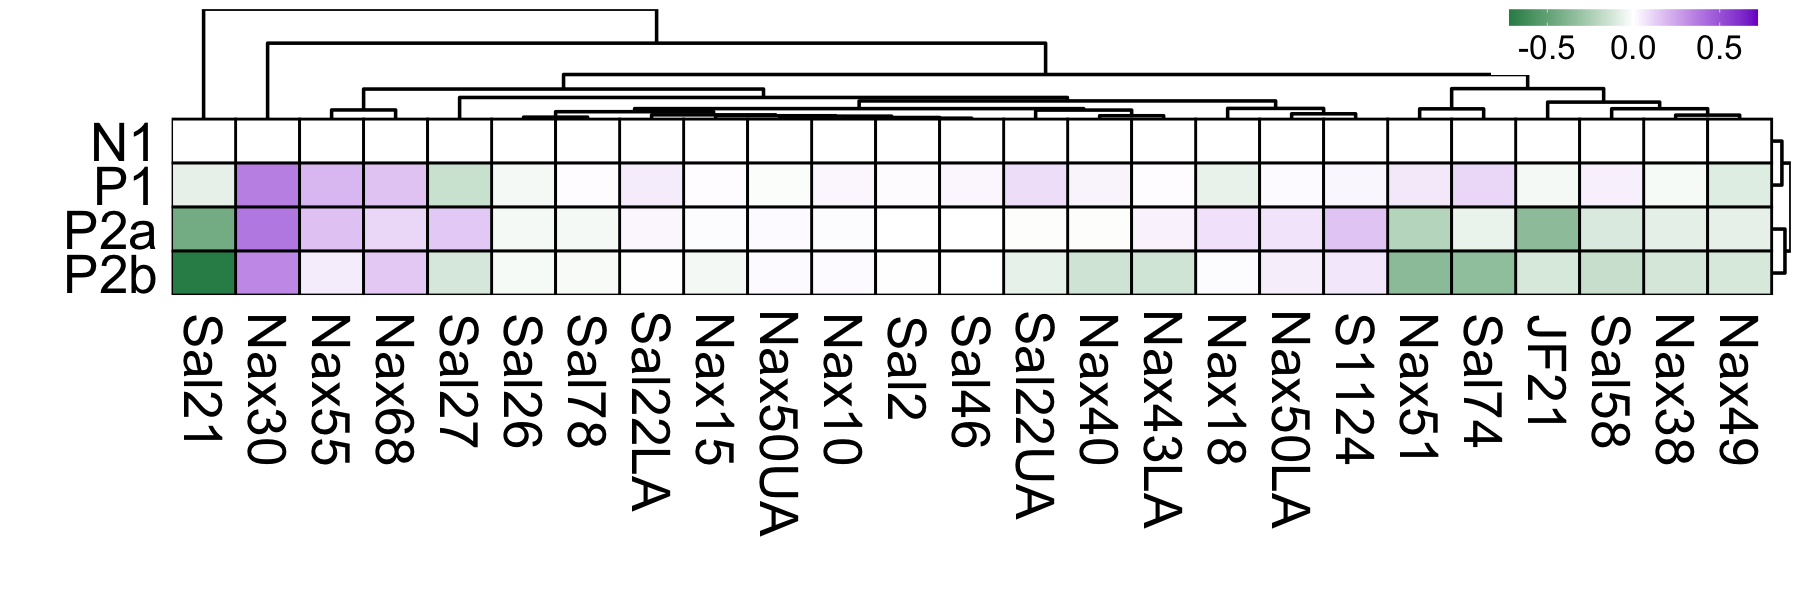

In [21]:
options(repr.plot.width = 15, repr.plot.height = 5)
# finding maximum value
max_value <-  max(abs(hm$value))

# creating heatmap
ggplot(hm, aes(x, y, fill = value)) +
    geom_tile(color = "black", size=0.8) +
    geom_dendro(colclust, ylim = c(4.5, 7), size = 1) +
    geom_dendro(rowclust, pointing = "side", xlim = c(25.5, 25.8), size = 1) +
    scale_fill_gradient2(low = "seagreen", mid = "white", high = "purple3", limits = c(-max_value, max_value),
    breaks = c(-0.5, 0, 0.5)) +
    theme_martin() +
    theme(
        axis.text.x = element_text(angle = -90, vjust=0.5, hjust=0.05), axis.line.y = element_blank(),
        axis.line.x = element_blank(), axis.ticks.y = element_blank(),
        axis.ticks.x = element_blank(), legend.title  =element_blank(), 
        legend.key.height= unit(10, 'pt'), legend.key.width= unit(30, 'pt'),
        legend.position = c(0.9, 0.9), legend.direction = "horizontal",  legend.text = element_text(size=20)
    ) +
    labs(y = "", x = "")
ggsave("../plots/Figure1/tm32_hm.pdf", height=8, width=14)

#### Custom clustermap:

In [5]:
# reading in pairwise L1
pairwise_l1_tm32 <- read_tsv("../results/lung_pairwise_l1_tm32b.tsv") 

Rows: 120 Columns: 9
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (5): a, b, subject, tumor_a, tumor_b
dbl (4): l1, r, marker, divs

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [30]:
# convert L1 to cell divisions:
subject_cell_div_table <- pairwise_l1_tm32 %>%
  filter(str_detect(a, "TM32")) %>%
  mutate(across(a:b, ~ str_remove(.x, "TM32"))) %>% 
  select(a,b, l1)

# adding L1 of one sample with itself (0)
zero_tbl <- tibble("a"=unique(subject_cell_div_table$a), "b"=unique(subject_cell_div_table$a), "l1"=0) %>% 
  bind_rows(tibble("a"=unique(subject_cell_div_table$b), "b"=unique(subject_cell_div_table$b), "l1"=0)) %>% 
  distinct()

dist_mat_int <- subject_cell_div_table %>% 
  bind_rows(zero_tbl) %>% 
  pivot_wider(names_from=a, values_from=l1)

# reordering the matrix to be in the correct order for the tree
dist_mat <- dist_mat_int[match(colnames(dist_mat_int), dist_mat_int$b) %>% na.omit, ] %>% 
  column_to_rownames("b")

##### Plotting distance matrix clustermaps
sym_dist_mat  <- as.dist(dist_mat, upper = TRUE)  %>% as.matrix()

In [31]:
# creating clusters and tables for clustermap plotting
rowclust <- hclust(as.dist(sym_dist_mat)) %>%
    dendextend::rotate(order=c(4,3,2,1))
colclust <- hclust(as.dist(t(sym_dist_mat))) 
hm <- hmReady(sym_dist_mat, colclus = colclust, rowclus = rowclust)

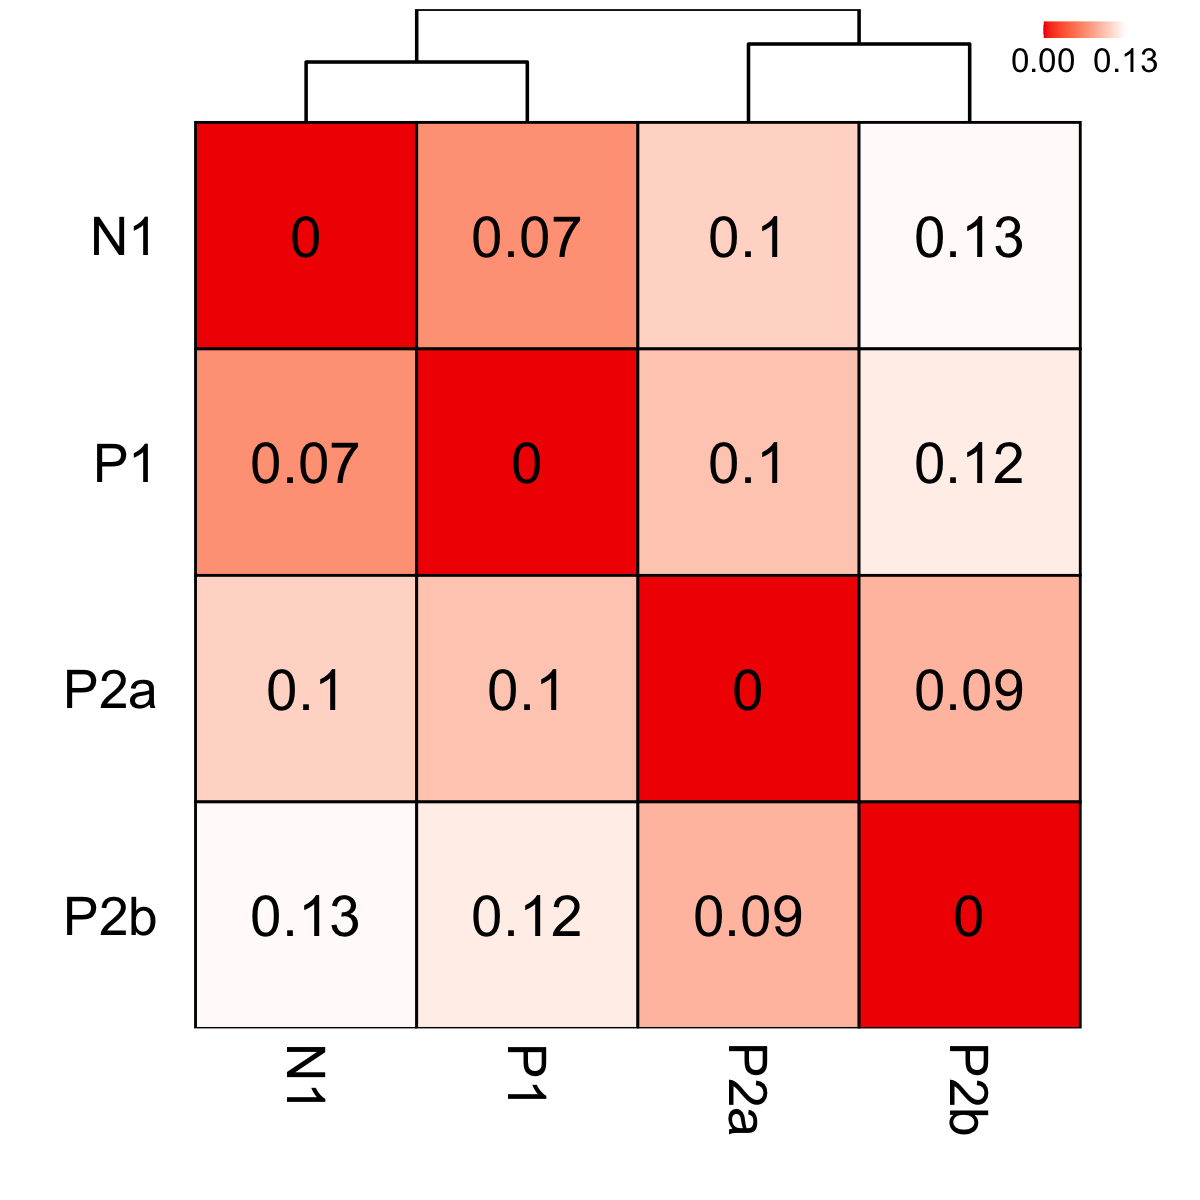

In [32]:
options(repr.plot.width = 10, repr.plot.height = 10)


# finding maximum value
max_value <-  max((hm$value))


# creating clustermap
ggplot(hm, aes(x, y, fill = value)) +
    geom_tile(color = "black", size = 0.8) +
    geom_text(aes(label=round(value, 2)), size=12) +
    geom_dendro(colclust, ylim = c(4.5, 5), size = 1) +
    geom_dendro(rowclust, pointing = "side",size = 1, color="white") +
    scale_fill_gradient(low = "#F21A00", high = "white", 
        limits = c(0, round(max_value, 2)), breaks= c(0, round(max_value, 2))) +
    theme_martin() +
    theme(
        axis.text.x = element_text(angle = -90, vjust=0.5, hjust=0.05), axis.line.y = element_blank(),
        axis.text.y = element_text(hjust=1, margin = margin(r = -50)),
        axis.line.x = element_blank(), axis.ticks.y = element_blank(),
        axis.ticks.x = element_blank(), legend.title  =element_blank(), 
        legend.key.height= unit(10, 'pt'), legend.key.width= unit(10, 'pt'),
        legend.position = c(0.9, 0.96), legend.direction = "horizontal",  legend.text = element_text(size=20)
    ) +
    coord_cartesian(xlim = c(0, 5)) +
        labs(y = "", x = "")
ggsave("../plots/Figure1/tm32_clustermap.pdf", height = 8, width = 8)

## L1 Distance Simulations

In [2]:
simulate_genotype  <- function(cell_divs, mu, markers) {
  
  lineage_mutations<-matrix(
    rbinom(n=markers*cell_divs,size=1,p=mu)*(2*rbinom(n=markers*cell_divs,size=1,p=0.5)-1)
    ,ncol=markers)
  genotype<-matrix(colSums(lineage_mutations),ncol=markers)
    
return(genotype)
}

In [3]:
# for a set number of cell divs (i), get the Manhattan distance in 1000 replicates
l1_for_cell_divs_with_del  <- function(i, mu, markers) {
    
l1  <- replicate(1000, sum(abs(simulate_genotype(i, mu, markers)))/markers)    
   list(l1=l1, divs=i) 
}

In [2]:
# for a set number of cell divs (i), get the Manhattan distance in 1000 replicates
l1_for_cell_divs_with_del_wgd  <- function(i, mu, markers) {
    
l1 <- replicate(1000, sum(abs(simulate_genotype(i, mu, markers*2))) / (markers * 2))
   list(l1=l1, divs=i) 
}

In [4]:
# µ = 4-e4
options(repr.plot.width=10, repr.plot.height=10)

l_2500mu_50mark_with_del <- mclapply(1:1000, l1_for_cell_divs_with_del, 4e-4, 50)
l_2500mu_20mark_with_del <- mclapply(1:1000, l1_for_cell_divs_with_del, 4e-4, 20)

In [ ]:
# µ = 9e-5
l_10000mu_50mark_with_del <- mclapply(1:1000, l1_for_cell_divs_with_del, 9e-5, 50)
l_10000mu_20mark_with_del <- mclapply(1:1000, l1_for_cell_divs_with_del, 9e-5, 20)

In [ ]:
data <- bind_rows(l_2500mu_20mark_with_del) %>%
    mutate(u = 40, n = "20 tracts", mu=4e-4) %>%
    bind_rows(bind_rows(l_2500mu_20mark_with_del) %>%
        mutate(u = 40, n = "50 tracts", mu=4e-4)) %>%
    bind_rows(bind_rows(l_10000mu_20mark_with_del) %>%
        mutate(u = 9, n = "20 tracts", mu=9e-5)) %>%
    bind_rows(bind_rows(l_10000mu_50mark_with_del) %>%
        mutate(u = 9, n = "50 tracts", mu=9e-5)) %>%
    group_by(u, mu, n, divs) %>%
    summarize(mean_l1 = mean(l1), 
             l1_95= quantile(l1,  0.975), 
             l1_05= quantile(l1,  0.025))  %>% 
    mutate(
        mean_l1 = rollmean(mean_l1, 10, fill = NA),
        l1_95 = rollmean(l1_95, 10, fill = NA),
        l1_05 = rollmean(l1_05, 10, fill = NA),
        exp_l1 = divs * mu
    ) 

`summarise()` has grouped output by 'u', 'mu', 'n'. You can override using the
`.groups` argument.


In [106]:
plot <- data %>%
    ggplot() +
        geom_line(aes(divs, exp_l1), linetype=2, size = 3, color="grey23") +
        geom_line(aes(divs, mean_l1), size = 2, color = "blue") +
        geom_ribbon(aes(x = divs, ymin = l1_05, ymax = l1_95), fill = "grey23", alpha = 0.2) +
        coord_cartesian(ylim = c(0, 0.6)) +
        labs(x = "Cell divisions", y = "L1") +
        theme_martin() +
    facet_grid(u~n, 
    labeller=label_bquote(mu == .(u) %*% 10^-5)
    )

Warning message:
"Removed 9 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 9 rows containing missing values (`geom_line()`)."


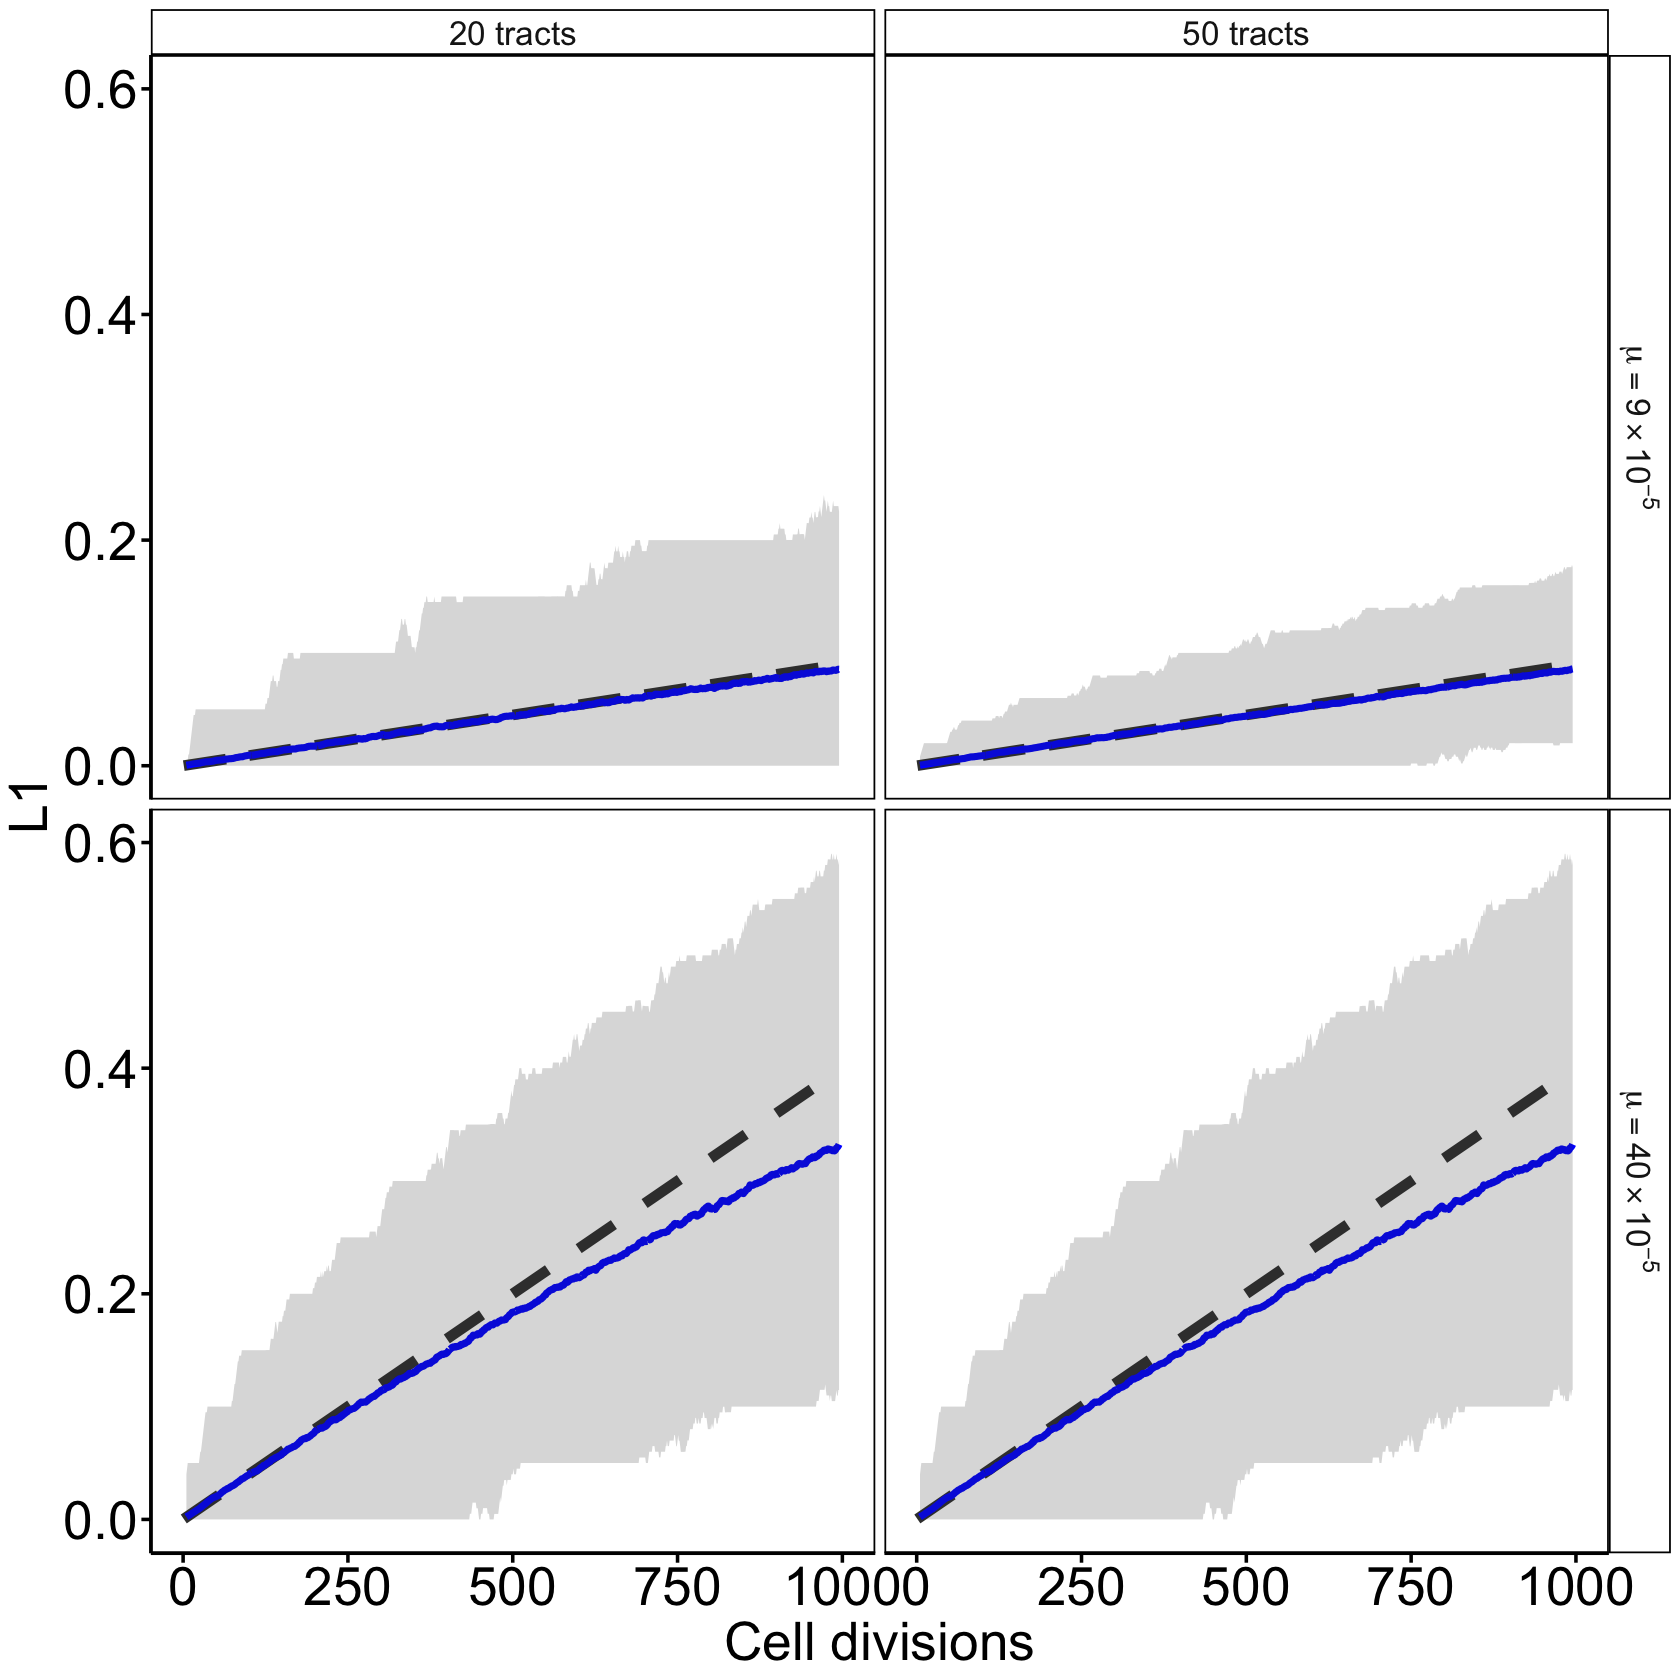

In [108]:
options(repr.plot.width=14, repr.plot.height=14)

plot +
    facet_grid(u~n, 
    labeller=label_bquote(mu == .(u) %*% 10^-5)
    ) +
    theme(
        strip.background = element_rect(color="black", size=1),
        panel.border = element_rect(colour = "black", fill = NA, size=1),
        strip.text = element_text(size = 20)
    )
ggsave("../plots/Figure1/Fig1D.pdf", width=11, height=7)

In [ ]:
l_2500mu_50mark_post_wgd <- mclapply(1:1000, l1_for_cell_divs_with_del_wgd, 4e-4, 50)

In [ ]:
wgd_data <- l_2500mu_50mark_post_wgd %>%
    bind_rows() %>% 
        mutate(u = 40, n = "50 tracts", mu=4e-4) %>%
    group_by(u, mu, n, divs) %>%
    summarize(mean_l1 = mean(l1), 
             l1_95= quantile(l1,  0.975), 
             l1_05= quantile(l1,  0.025))  %>% 
    mutate(
        mean_l1 = rollmean(mean_l1, 10, fill = NA),
        l1_95 = rollmean(l1_95, 10, fill = NA),
        l1_05 = rollmean(l1_05, 10, fill = NA),
        exp_l1 = divs * mu
    ) 

`summarise()` has grouped output by 'u', 'mu', 'n'. You can override using the
`.groups` argument.


In [19]:
write_tsv(wgd_data, "../results/wgd_sim.tsv")

In [5]:
wgd_data <- read_tsv("../results/wgd_sim.tsv")

Rows: 1000 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (1): n
dbl (7): u, mu, divs, mean_l1, l1_95, l1_05, exp_l1

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
wgd_plot <- wgd_data %>%
    ggplot() +
    geom_line(aes(divs, exp_l1), linetype = 2, size = 3, color = "grey23") +
    geom_line(aes(divs, mean_l1), size = 2, color = "blue") +
    geom_ribbon(aes(x = divs, ymin = l1_05, ymax = l1_95), fill = "grey23", alpha = 0.2) +
    coord_cartesian(xlim=c(0,1050)) +
    labs(x = "Cell divisions", y = "L1") +
    theme_martin()

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


In [7]:
no_wgd_plot <-l_2500mu_50mark_with_del %>%
        bind_rows() %>% 
        mutate(u = 40, n = "50 tracts", mu=4e-4) %>%
    group_by(u, mu, n, divs) %>%
    summarize(mean_l1 = mean(l1), 
             l1_95= quantile(l1,  0.975), 
             l1_05= quantile(l1,  0.025))  %>% 
    mutate(
        mean_l1 = rollmean(mean_l1, 10, fill = NA),
        l1_95 = rollmean(l1_95, 10, fill = NA),
        l1_05 = rollmean(l1_05, 10, fill = NA),
        exp_l1 = divs * mu
    ) %>% 
    ggplot() +
    geom_line(aes(divs, exp_l1), linetype = 2, size = 3, color = "grey23") +
    geom_line(aes(divs, mean_l1), size = 2, color = "blue") +
    geom_ribbon(aes(x = divs, ymin = l1_05, ymax = l1_95), fill = "grey23", alpha = 0.2) +
    coord_cartesian(xlim=c(0,1050)) +
    labs(x = "Cell divisions", y = "L1") +
    theme_martin()

`summarise()` has grouped output by 'u', 'mu', 'n'. You can override using the
`.groups` argument.


Warning message:
"Removed 9 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 9 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 9 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 9 rows containing missing values or values outside the scale range
(`geom_line()`)."


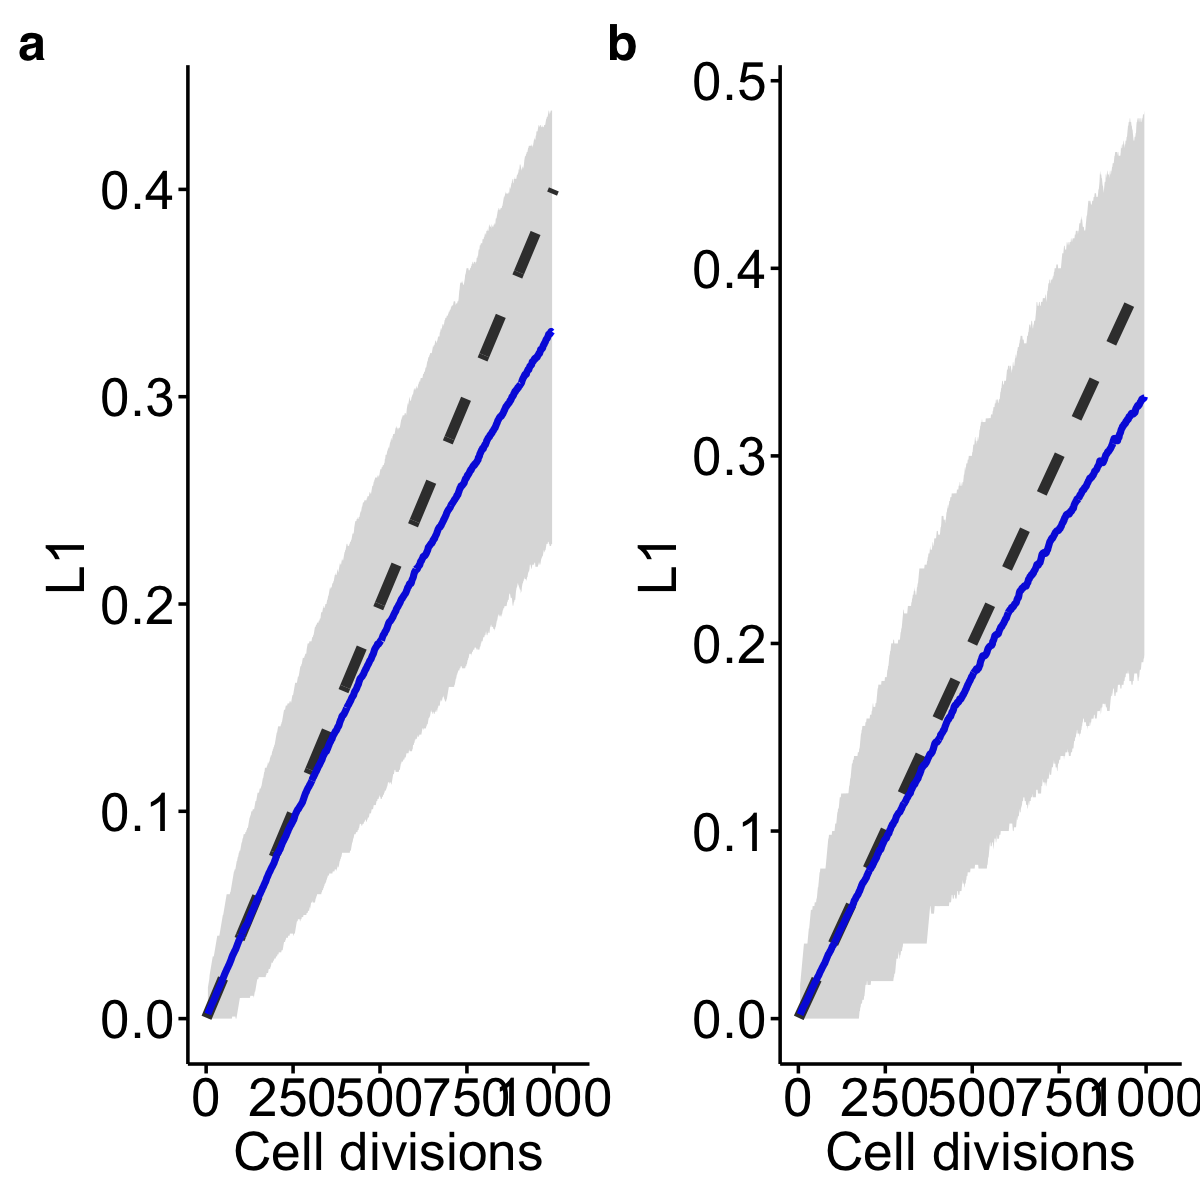

In [12]:
(wgd_plot | no_wgd_plot) +
    plot_annotation(tag_levels = 'a') &
    theme(plot.tag = element_text(face = "bold", family="Helvetica", size=30)) 

    ggsave("../plots/Figure1/WGD_sim.pdf", width = 14, height = 7)

## Simulating purity for Supplementary Note 4

In [1]:
simulate_purity  <- function(cell_divs, mu, markers, purity) {
  
lineage_mutations<-matrix(
    rbinom(n=markers*cell_divs,size=1,p=mu)*(2*rbinom(n=markers*cell_divs,size=1,p=0.5)-1)
    ,ncol=markers)
  genotype <- matrix(colSums(lineage_mutations), ncol = markers)
  normal <- rep(0, markers)
  impure_genotype <- (genotype * purity) + (normal * (1 - purity))
    
return(impure_genotype)
}

In [2]:
replicate_l1 <- function(purity, i, mu, markers) {

l1  <- replicate(1000, sum(abs(simulate_purity(i, mu, markers, purity)))/markers)    

list(l1=l1, divs=i, purity=purity) 

}

In [3]:
# for a set number of cell divs (i), get the Manhattan distance in 1000 replicates
l1_for_cell_divs_impure  <- function(i, mu, markers) {
    
    lapply(c(0.25, 0.5, 0.75, 1), replicate_l1, i, mu, markers)

}

In [6]:
l_impure_msi <- mclapply(1:1000, l1_for_cell_divs_impure, 4e-4, 50)

In [8]:
l_impure_msi %>%
    bind_rows() %>% 
    write_tsv("../results/purity_simulation.tsv")

In [24]:
colorRampPalette(RColorBrewer::brewer.pal(9, "Blues"))(8)[6:3]

[1] "#2A7AB9" "#539ECC" "#88BEDC" "#BAD6EB"

`summarise()` has grouped output by 'purity'. You can override using the
`.groups` argument.
Warning message:
"Removed 36 rows containing missing values or values outside the scale range
(`geom_line()`)."
Saving 7 x 7 in image
Warning message:
"Removed 36 rows containing missing values or values outside the scale range
(`geom_line()`)."


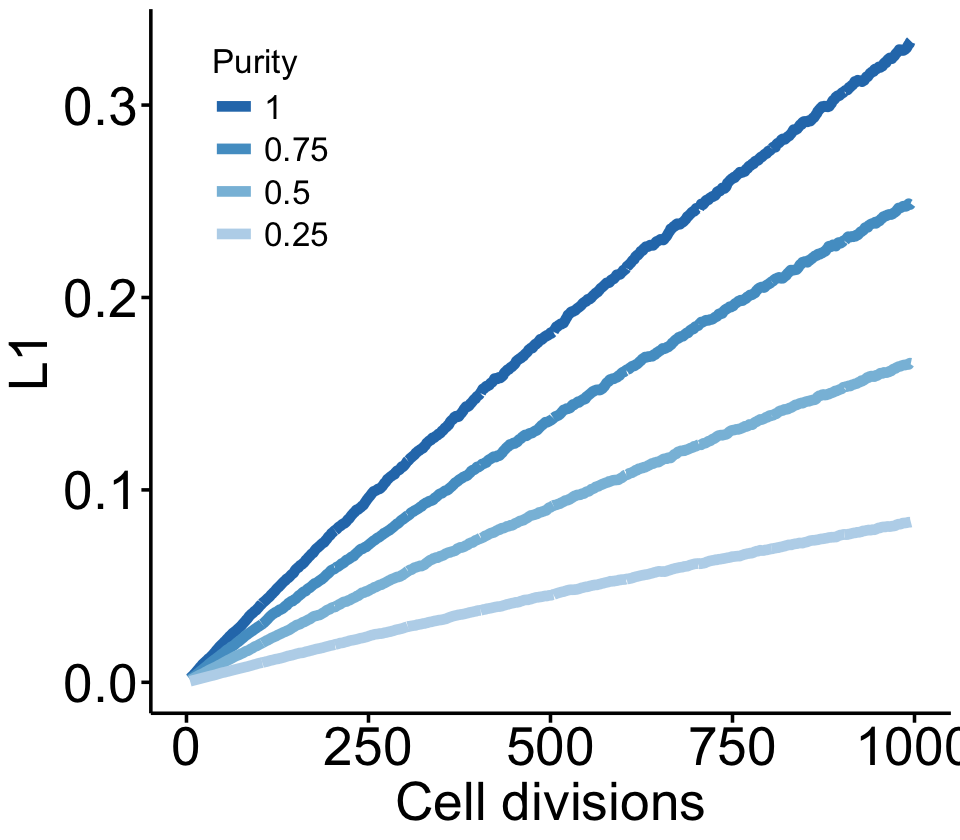

In [38]:
options(repr.plot.width=8, repr.plot.height=7)
l_impure_msi %>%
    bind_rows() %>%
    group_by(purity, divs) %>%
    summarize(mean_l1 = mean(l1)) %>%
    mutate(
        mean_l1 = rollmean(mean_l1, 10, fill = NA),
        purity = as.factor(purity), purity = fct_relevel(purity, "1", "0.75", "0.5", "0.25")
    ) %>% 
    ggplot(aes(divs, mean_l1, color = purity, group = purity)) +
        geom_line(size = 3) +
        scale_color_manual(values = colorRampPalette(RColorBrewer::brewer.pal(9, "Blues"))(8)[6:3], name = "Purity") +
        labs(x = "Cell divisions", y = "L1") +
        theme_martin() +
        theme(
            legend.position = c(0.15, 0.8), legend.text = element_text(size = 20),
            legend.key.size = unit(0.9, "cm"), legend.title = element_text(size = 20)
        )
    ggsave("../plots/Figure1/purity_sim.pdf")

## Do subclonal mutations effect L1?

### Simulating a branching process

Simulating the branching process of 1,000 expanding cells

In [92]:
expansion_mutations_500 <- function() {
  N <- 10000 #number of cells sampled
  partition_sizes <- N
  d1 <- 500
  v <- 0.0004
  L <- 50
  mutations <- matrix(0, nrow = N, ncol = L)
  l = list()
  for (n in 1:d1) {
    if (length(partition_sizes) < N) {
      partition_sizes_w_0 <-
        c(sapply(partition_sizes, function(size) {
          size1 <- rbinom(n = 1, size = size, prob = 0.5)
          c(size1, size - size1)
        }))

      partition_sizes <- partition_sizes_w_0[partition_sizes_w_0 != 0]
    }
    n_lineages <- length(partition_sizes)
    new_mutations <-
      matrix(rbinom(n = L * n_lineages, size = 1, p = v) * (2 * rbinom(n = L * n_lineages, size = 1, p = 0.5) - 1),
        ncol = L
      )
    new_mutations_resized <- new_mutations[rep(1:nrow(new_mutations), times = partition_sizes), ]
    mutations <- mutations + new_mutations_resized
    l[[n]] <- mutations
  }
  l
}

Simulating divisions before and after clonal expansion

In [67]:
get_l1_subclonal <- function(i, l, lineage_mutations_total, L) {

  expa_mut <- l[[i]]

  sample_genotype <- expa_mut + lineage_mutations_total[rep(1, nrow(expa_mut)), ]

  sample_genotype <- matrix(sample_genotype, ncol = L)

  mean_lengths <- colMeans(sample_genotype)

  l1 <- mean(abs(mean_lengths))

  l1_list <- list(l1=l1, divs=i)
}

In [93]:
#d0 and d1 are respectively 
#number of divisions from zygote to mrca and
#number of divisions from mrca to sample
zygote_to_sample<-function(d0,subclonal_expansion){
  
L<-50 #number of tracts
v = 0.0004 # mutation rate per tract per division

  if (d0>0){
  
  lineage_mutations<-matrix(
    rbinom(n=L*d0,size=1,p=v)*(2*rbinom(n=L*d0,size=1,p=0.5)-1)
    ,ncol=L)
  lineage_mutations_total<-matrix(colSums(lineage_mutations),ncol=L)
  } else {

    lineage_mutations_total<-matrix(0,nrow=1,ncol=L)
  
  }

  if (subclonal_expansion) {
  l <- expansion_mutations_500() 
  l1_list <- mclapply(1:length(l), get_l1_subclonal, l, lineage_mutations_total, L)
  bind_rows(l1_list)
  } else { tibble(divs=d0, l1=sum(abs(lineage_mutations_total)/L)) }

}



In [96]:
clonal <- replicate(1000, mclapply(1:500, zygote_to_sample, FALSE))
clonal <- bind_rows(clonal)

In [94]:
subclonal <- replicate(1000, zygote_to_sample(500, TRUE), simplify = FALSE)
subclonal <- bind_rows(subclonal)

In [97]:
branch_proc_mut <- subclonal %>%
    mutate(divs = divs + 500)%>%
    bind_rows(clonal)

In [98]:
write_tsv(branch_proc_mut, "../results/branch_proc_mut.tsv")

### Plotting clonal and subclonal mutations

In [21]:
branch_proc_mut <- read_tsv("../results/branch_proc_mut.tsv")

Rows: 1000000 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: "\t"
dbl (2): l1, divs

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
clonal <- branch_proc_mut %>%
    group_by(divs) %>%
    mutate(clonal = ifelse(divs > 500, FALSE, TRUE)) %>%
    filter(divs >= 500, clonal) %>%
    pull(l1)

subclonal <- branch_proc_mut %>%
    group_by(divs) %>%
    mutate(clonal = ifelse(divs > 500, FALSE, TRUE)) %>%
    filter(divs == 1000, !clonal) %>%
    pull(l1)

Warning message:
"Removed 9 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 9 rows containing missing values (`geom_line()`)."


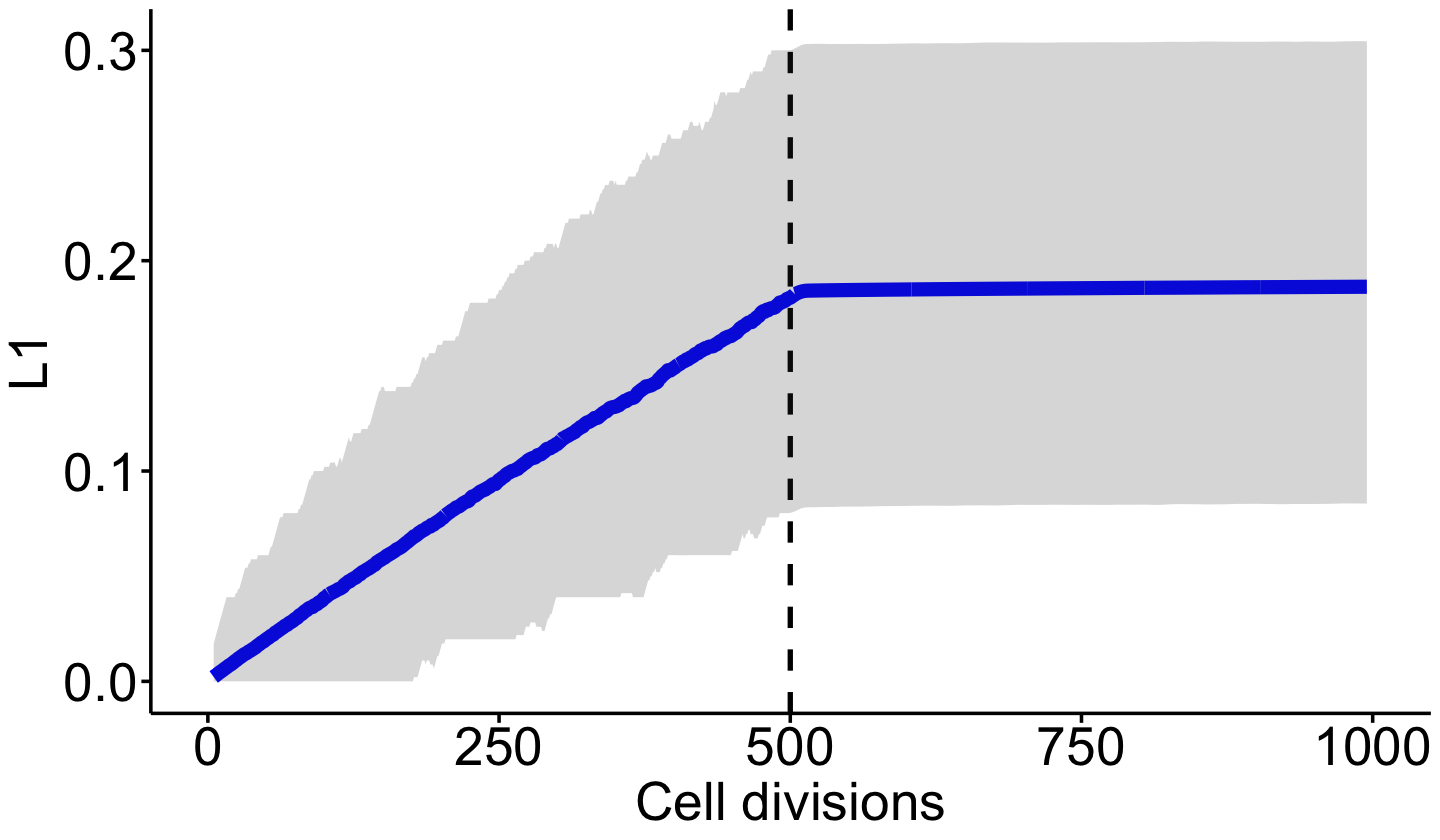

In [26]:
options(repr.plot.width=12, repr.plot.height=7)


branch_proc_mut %>%  
    group_by(divs)  %>% 
    summarize(mean_l1 = mean(l1), 
             l1_95= quantile(l1,  0.975), 
             l1_05= quantile(l1,  0.025))  %>% 
    mutate(mean_l1 = rollmean(mean_l1, 10, fill = NA),
    l1_95 = rollmean(l1_95, 10, fill=NA),
    l1_05 = rollmean(l1_05, 10, fill=NA)) %>% 
        ggplot() +
        geom_line(aes(divs, mean_l1), size = 4, color = "blue") +
        geom_vline(xintercept = 500, linetype = 2, size = 1.5) +
        geom_ribbon(aes(x = divs, ymin = l1_05, ymax = l1_95), fill = "grey23", alpha = 0.2) +
        #annotate("text", x=50, y=0.31, label="clonal", size=15, hjust = 0 ) +
        #annotate("text", x=550, y=0.31, label="subclonal", size=15, hjust = 0 ) +
        labs(x = "Cell divisions", y = "L1") +
        theme_martin()
ggsave("../plots/Figure1/Figure1E.pdf", height=6, width=11)

Percent difference in L1 burden between cancer initiation and cancer sampling.

In [23]:
(mean(subclonal) - mean(clonal)) / mean(clonal) * 100

[1] 2.004716